In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime
from scipy.optimize import fsolve
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
from functools import reduce
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import random

### Reading and Cleaning Risk Free Rate Data

In [2]:
rf_data = pd.read_csv("DTB3.csv",low_memory=False)

In [3]:
rf_data.head()

,DATE,DTB3
0,1970-01-02,7.920
1,1970-01-05,7.910
2,1970-01-06,7.930
3,1970-01-07,7.900
4,1970-01-08,7.910


In [4]:
rf_data = rf_data.rename(columns={"DATE": "date", "DTB3": "rf"})
rf_data['rf'] = rf_data['rf'].replace('.', np.nan)
rf_data['rf'] = pd.to_numeric(rf_data['rf'], errors='coerce')
rf_data['rf'].fillna(method='bfill', inplace=True)
rf_data['date'] = pd.to_datetime(rf_data['date'])
rf_data['year'] = rf_data['date'].dt.year
rf_data = rf_data.groupby('year').agg({'rf': lambda x: math.log1p(x.iloc[0] / 100)}).reset_index()

In [5]:
rf_data.head()

,year,rf
0,1970,0.076220
1,1971,0.047742
2,1972,0.036235
3,1973,0.050883
4,1974,0.072507


### Reading and Cleaning CRSP Data

In [6]:
dsf_data = pd.read_csv('dsf_data.csv', low_memory=False,parse_dates=['date'], usecols= ['PERMNO','CUSIP','date','PRC','SHROUT','RET'])

In [7]:
dsf_data = dsf_data.sort_values(by=['date'])

In [8]:
dsf_data.head()

,PERMNO,date,CUSIP,PRC,RET,SHROUT
8855282,14197,1970-01-02,76125210,21.750,0.060976,1550.0
21670934,31480,1970-01-02,27631710,-24.500,0.015544,426.0
25555162,39175,1970-01-02,71654410,40.750,0.006173,2257.0
14842968,19692,1970-01-02,04238410,34.875,-0.014134,25462.0
27399007,42577,1970-01-02,82658810,12.125,0.010417,707.0


In [9]:
# Convert CUSIP to string
dsf_data['CUSIP'] = dsf_data['CUSIP'].astype(str)

# Convert RET to float, coercing errors to NaN
dsf_data['RET'] = pd.to_numeric(dsf_data['RET'], errors='coerce')


In [10]:
# Convert 'PRC', 'RET', and 'SHROUT' to numeric, coercing errors to NaN
dsf_data['PRC'] = pd.to_numeric(dsf_data['PRC'], errors='coerce')
dsf_data['RET'] = pd.to_numeric(dsf_data['RET'], errors='coerce')
dsf_data['SHROUT'] = pd.to_numeric(dsf_data['SHROUT'], errors='coerce')

# Sort the DataFrame by PERMNO and date to ensure correct forward filling
dsf_data = dsf_data.sort_values(by=['PERMNO', 'date'])

# Forward fill the missing values for each 'PERMNO'
dsf_data[['PRC', 'RET', 'SHROUT']] = dsf_data.groupby('PERMNO')[['PRC', 'RET', 'SHROUT']].ffill()

In [11]:
# Define a function to fill NAs with group-specific mean
def fill_na_with_group_mean(df, column_name):
    return df.groupby('PERMNO')[column_name].transform(lambda x: x.fillna(x.mean()))

# Apply this function to each column with missing values
for column in ['PRC', 'RET', 'SHROUT']:
    dsf_data[column] = fill_na_with_group_mean(dsf_data, column)

In [12]:
dsf_data = dsf_data.rename(columns=str.lower)
dsf_data['year'] = dsf_data['date'].dt.year
dsf_data['cusip'] = dsf_data['cusip'].str[:6]
dsf_data['market_cap'] = abs(dsf_data['prc'] * (dsf_data['shrout'] * 1000))

# Convert 'ret' to numeric, dropping NaN values in the process
dsf_data['ret'] = pd.to_numeric(dsf_data['ret'], errors='coerce')
dsf_data.dropna(inplace=True)

In [13]:
dsf_data.tail()

,permno,date,cusip,prc,ret,shrout,year,market_cap
85432777,93436,2020-12-24,88160R,661.77002,0.024444,947901.0,2020,6.272925e+11
85432778,93436,2020-12-28,88160R,663.69000,0.002901,947901.0,2020,6.291124e+11
85432779,93436,2020-12-29,88160R,665.98999,0.003465,947901.0,2020,6.312926e+11
85432780,93436,2020-12-30,88160R,694.78003,0.043229,947901.0,2020,6.585827e+11
85432781,93436,2020-12-31,88160R,705.66998,0.015674,959854.0,2020,6.773402e+11


### Reading and Cleaning COMPUSTAT Data

In [14]:
# Specify the columns you want to read
required_columns = ['cusip','fyear', 'datadate', 'dlc', 'dltt', 'indfmt', 'datafmt', 'popsrc', 'fic', 'consol', 'fyear']

# Read the first 10 rows of the Compustat data file with only the required columns
compustat_data = pd.read_csv('funda_2022.csv', parse_dates=['datadate'],usecols=required_columns,low_memory=False, dtype={"fic": "string"})


In [15]:
compustat_data = compustat_data.loc[
    (compustat_data['indfmt'] == 'INDL') & 
    (compustat_data['datafmt'] == "STD") & 
    (compustat_data['popsrc'] == "D") & 
    (compustat_data['fic'] == "USA") & 
    (compustat_data['consol'] == 'C') &
    (compustat_data['fyear'] >= 1970) & 
    (compustat_data['fyear'] <= 2020)
]

compustat_data = compustat_data[['cusip', 'fyear', 'datadate', 'dlc', 'dltt']]
compustat_data['cusip'] = compustat_data['cusip'].str[0:6]
compustat_data['dlc'] = compustat_data['dlc'] * 1000000 
compustat_data['dltt'] = compustat_data['dltt'] * 1000000

# Create a lagged year column
compustat_data['lagged_fyear'] = compustat_data['fyear'] + 1

In [16]:
# Calculate 'debt' as the sum of 'dlc' and half of 'dltt'
compustat_data['debt'] = compustat_data['dlc'] + (0.5 * compustat_data['dltt'])

# Rename 'fyear' to 'year', filter columns, and cast 'year' to int
compustat_data = compustat_data.rename(columns={"lagged_fyear": "year"})[['cusip', 'year', 'debt']]
compustat_data['year'] = compustat_data['year'].astype(int)

# Filter out rows with 'debt' <= 0, drop NaN values, and remove duplicates
compustat_data = compustat_data[compustat_data['debt'] > 0].dropna().drop_duplicates()

In [17]:
compustat_data.head()

,cusip,year,debt
9,000032,1971,12836500.0
10,000032,1972,8016000.0
11,000032,1973,3500000.0
12,000032,1974,3500000.0
13,000032,1975,4000000.0


### Merging DataFrames

In [18]:
annret = dsf_data.groupby(['cusip', 'year'], as_index=False).apply(
    lambda x: np.exp(np.sum(np.log(1 + x['ret'])))
).rename(columns={0: "annual_ret"}).dropna()
annret = annret.rename(columns={annret.columns[-1]: "Annual_returns"})

# Calculate annual volatility
sigmae = dsf_data.groupby(['cusip', 'year'])['ret'].agg(
    Annual_Standard_Deviation=lambda x: np.std(x) * np.sqrt(250)
).reset_index().dropna()

# Get first market cap value for each cusip, year
E = dsf_data.groupby(['cusip', 'year'], as_index=False)['market_cap'].first()

# Combine computed values with dsf dataframe, compustat
df_x = [E, sigmae, annret, compustat_data]
dsf_data_merged = reduce(lambda left, right: pd.merge(left, right, on=['cusip', 'year'], how='inner'), df_x)

In [19]:
dsf_data_merged = pd.merge(dsf_data_merged, rf_data, how = 'left', on = ['year'] )
dsf_data_merged.dropna(inplace=True)

In [20]:
dsf_data_merged.head()

,cusip,year,market_cap,Annual_Standard_Deviation,Annual_returns,debt,rf
0,000032,1971,24226875.0,0.675765,0.574997,12836500.0,0.047742
1,000032,1972,14602500.0,0.587679,0.833174,8016000.0,0.036235
2,000032,1973,14602500.0,0.831766,0.341465,3500000.0,0.050883
3,000032,1974,4978125.0,0.777654,1.214281,3500000.0,0.072507
4,000032,1975,4711125.0,0.694539,2.058824,4000000.0,0.066724


### Distanace to Default Computation - Method 1 (Naive)

In [21]:
merged_data_random_sample = dsf_data_merged[dsf_data_merged['year'] >= 1972].groupby('year').sample(n=1000, random_state=1).reset_index(drop=True)

In [22]:
# Calculating different weighted standard deviations for debt based on naive weighting of weights
debt_weights = np.array([0.25, 0.5, 0.25])
additional_values = np.where(debt_weights != 0.25, 0.05, 0.0)

# Using NumPy broadcasting for efficient computation
debt_std_devs = merged_data_random_sample['Annual_Standard_Deviation'].values[:, None] * debt_weights + additional_values
for i, debt_std_dev in enumerate(debt_std_devs.T, start=1):
    merged_data_random_sample[f'Annual_Standard_Deviation_Debt{i}'] = debt_std_dev

# Calculating the total value
merged_data_random_sample['Value'] = merged_data_random_sample['market_cap'] + merged_data_random_sample['debt']

# Calculating different standard deviations for the total value
for i in range(1, 4):
    merged_data_random_sample[f'Annual_Standard_Deviation_Value{i}'] = (
        merged_data_random_sample['market_cap'] * merged_data_random_sample['Annual_Standard_Deviation'] +
        merged_data_random_sample['debt'] * merged_data_random_sample[f'Annual_Standard_Deviation_Debt{i}']
    ) / merged_data_random_sample['Value']

# Calculating the distance to default
for i in range(1, 4):
    std_dev_value_col = merged_data_random_sample[f'Annual_Standard_Deviation_Value{i}']
    merged_data_random_sample[f'distance_default_{i}'] = (
        np.log(merged_data_random_sample['Value'] / merged_data_random_sample['debt']) +
        merged_data_random_sample['Annual_returns'] - std_dev_value_col ** 2 / 2
    ) / std_dev_value_col

In [23]:
merged_data_random_sample.head()

,cusip,year,market_cap,Annual_Standard_Deviation,Annual_returns,debt,rf,Annual_Standard_Deviation_Debt1,Annual_Standard_Deviation_Debt2,Annual_Standard_Deviation_Debt3,Value,Annual_Standard_Deviation_Value1,Annual_Standard_Deviation_Value2,Annual_Standard_Deviation_Value3,distance_default_1,distance_default_2,distance_default_3
0,379568,1972,43532500.0,0.269155,1.142764,23314000.0,0.036235,0.067289,0.184577,0.067289,66846500.0,0.198750,0.239657,0.198750,10.950223,9.043729,10.950223
1,037519,1972,57768375.0,0.315903,1.106508,35299000.0,0.036235,0.078976,0.207951,0.078976,93067375.0,0.226040,0.274959,0.226040,9.071088,7.412664,9.071088
2,768024,1972,46156000.0,0.206570,1.010766,2343500.0,0.036235,0.051643,0.153285,0.051643,48499500.0,0.199084,0.203996,0.199084,20.196752,19.705645,20.196752
3,008315,1972,13118625.0,0.246789,0.928273,7909000.0,0.036235,0.061697,0.173395,0.061697,21027625.0,0.177172,0.219184,0.177172,10.669948,8.586799,10.669948
4,854412,1972,18411750.0,0.423680,0.871241,1903500.0,0.036235,0.105920,0.261840,0.105920,20315250.0,0.393906,0.408516,0.393906,8.025607,7.724246,8.025607


### Distanace to Default Computation - Method 2 (Directly Solving for the Unknowns)

In [24]:
def solve_equations(E, F, r, sigmaE):
    def equations(p):
        V, std_dev = p
        d1 = (np.log(V/F) + (r + 0.5 * std_dev**2)) / std_dev
        d2 = d1 - std_dev
        return (E - V * norm.cdf(d1) + np.exp(-r) * F * norm.cdf(d2), sigmaE - (V/E) * std_dev * norm.cdf(d1))

    initial_guess = (E + F, sigmaE * E / (E + F))
    return fsolve(equations, initial_guess)

In [25]:
# Extracting columns to avoid repeated lookups
market_caps = merged_data_random_sample['market_cap'].values
debts = merged_data_random_sample['debt'].values
rfs = merged_data_random_sample['rf'].values
sigmaEs = merged_data_random_sample['Annual_Standard_Deviation'].values

# Solving equations for each row
results = [solve_equations(E, F, r, sigmaE) for E, F, r, sigmaE in zip(market_caps, debts, rfs, sigmaEs)]

# Splitting the results into two lists
firm_values, firm_std_deviations = zip(*results)

# Adding the results to the DataFrame
merged_data_random_sample['Value_Firm_Method_2'] = firm_values
merged_data_random_sample['Standard_Dev_Firm_Method_2'] = firm_std_deviations

# Calculating the distance to default using Method 2
merged_data_random_sample['distance_default_Method_2'] = (
    np.log(merged_data_random_sample['Value_Firm_Method_2'] / merged_data_random_sample['debt']) +
    merged_data_random_sample['Annual_returns'] -
    merged_data_random_sample['Standard_Dev_Firm_Method_2'] ** 2 / 2
) / merged_data_random_sample['Standard_Dev_Firm_Method_2']


In [26]:
merged_data_random_sample.head()

,cusip,year,market_cap,Annual_Standard_Deviation,Annual_returns,debt,rf,Annual_Standard_Deviation_Debt1,Annual_Standard_Deviation_Debt2,Annual_Standard_Deviation_Debt3,Value,Annual_Standard_Deviation_Value1,Annual_Standard_Deviation_Value2,Annual_Standard_Deviation_Value3,distance_default_1,distance_default_2,distance_default_3,Value_Firm_Method_2,Standard_Dev_Firm_Method_2,distance_default_Method_2
0,379568,1972,43532500.0,0.269155,1.142764,23314000.0,0.036235,0.067289,0.184577,0.067289,66846500.0,0.198750,0.239657,0.198750,10.950223,9.043729,10.950223,6.601683e+07,0.177484,12.214420
1,037519,1972,57768375.0,0.315903,1.106508,35299000.0,0.036235,0.078976,0.207951,0.078976,93067375.0,0.226040,0.274959,0.226040,9.071088,7.412664,9.071088,9.181119e+07,0.198768,10.276452
2,768024,1972,46156000.0,0.206570,1.010766,2343500.0,0.036235,0.051643,0.153285,0.051643,48499500.0,0.199084,0.203996,0.199084,20.196752,19.705645,20.196752,4.841610e+07,0.196928,20.411376
3,008315,1972,13118625.0,0.246789,0.928273,7909000.0,0.036235,0.061697,0.173395,0.061697,21027625.0,0.177172,0.219184,0.177172,10.669948,8.586799,10.669948,2.074617e+07,0.156054,12.050012
4,854412,1972,18411750.0,0.423680,0.871241,1903500.0,0.036235,0.105920,0.261840,0.105920,20315250.0,0.393906,0.408516,0.393906,8.025607,7.724246,8.025607,2.024751e+07,0.385267,8.205654


### Distanace to Default Computation - Method 3 (Iterative Method)

In [27]:
dd_iterative_method_3 = pd.merge(dsf_data, compustat_data, how = 'left', on = ['year', 'cusip'])
dd_iterative_method_3 = dd_iterative_method_3.groupby(['cusip', 'year']).filter(lambda x: len(x) >= 150)
dd_iterative_method_3 =  pd.merge(dd_iterative_method_3, sigmae, how = 'left', on = ['year', 'cusip'])
dd_iterative_method_3 =  pd.merge(dd_iterative_method_3, rf_data, how = 'left', on = ['year'])
dd_iterative_method_3['Standard_Dev_Firm_Method_3'] = dd_iterative_method_3['Annual_Standard_Deviation']

In [28]:
def iterative_volatility_estimation(data):
    max_iterations = 20
    current_volatility = 2
    previous_volatility = 1

    for _ in range(max_iterations):
        # Calculating the firm's value using the Black-Scholes model
        firm_values = [
            fsolve(lambda V: black_scholes_equation(V, row), 
                   row['market_cap'] + row['debt'])[0] 
            for _, row in data.iterrows()
        ]

        # Update the standard deviations
        previous_volatility = current_volatility
        log_returns = np.diff(np.log(np.array(firm_values)))
        current_volatility = np.std(log_returns) * np.sqrt(250)

        # Break the loop if the change in volatility is below the threshold
        if abs(current_volatility / previous_volatility - 1) <= 0.05:
            break

        data['sigmav'] = previous_volatility

    return firm_values

def black_scholes_equation(V, row):
    E, F, r, sigmaV, sigmaE = row['market_cap'], row['debt'], row['rf'], row['Standard_Dev_Firm_Method_3'], row['Annual_Standard_Deviation']
    d1 = (np.log(V/F) + (r + 0.5 * sigmaV ** 2)) / sigmaV
    d2 = d1 - sigmaV
    return E - V * norm.cdf(d1) + math.exp(-r) * F * norm.cdf(d2)


In [29]:
# Removing any rows with missing values in dd_iterative_method_3 DataFrame
dd_iterative_method_3.dropna(inplace=True)
# Extracting unique 'cusip' values from dd_iterative_method_3 and converting them into a list
cusip_new = dd_iterative_method_3['cusip'].unique().tolist()
# Extracting unique 'year' values from dd_iterative_method_3 and converting them into a list
year_new = dd_iterative_method_3['year'].unique().tolist()

In [30]:
dd_m3 = []  # dd_m3 is a list that will store the results

# Function to process each CUSIP
def process_cusip(cusip, df_unique_year):
    # Filter DataFrame for the current CUSIP
    new_df = df_unique_year[df_unique_year['cusip'] == cusip].copy()

    if not new_df.empty:
        # Calculate values using iterative_volatility_estimation and add to DataFrame
        new_df['v'] = iterative_volatility_estimation(new_df)
        return new_df

# Loop through each year in unique_years, skipping the first year
for y in tqdm(year_new[1:]):
    # Filter for the current year
    df_unique_year = dd_iterative_method_3[dd_iterative_method_3['year'] == y]
    
    # Get unique CUSIPs for the current year
    unique_cusip = df_unique_year['cusip'].unique().tolist()
    
    # Randomly select 250 CUSIPs (or all if there are less than 250)
    cusip_random = random.sample(unique_cusip, min(len(unique_cusip), 250))

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers = 200) as executor:
        # Process each CUSIP in parallel
        results = list(executor.map(lambda c: process_cusip(c, df_unique_year), cusip_random))

    # Add non-empty results to dd_m3
    dd_m3.extend([result for result in results if result is not None and not result.empty])

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [4:49:24<00:00, 354.38s/it]


In [31]:
dd_iterative_df = pd.concat(dd_m3, ignore_index=True)
dd_iterative_df = pd.merge(dd_iterative_df,annret,  on=['cusip','year'], how = 'left' )
dd_iterative_df['distance_default_method_3'] = (np.log(dd_iterative_df['v']/dd_iterative_df['debt']) + (dd_iterative_df['Annual_returns'] - (dd_iterative_df['sigmav']**2)/2))/dd_iterative_df['sigmav']
dd_iterative_df['prob_default_method_3'] = norm.cdf(-dd_iterative_df['distance_default_method_3'])
dd_iterative_df = dd_iterative_df[~dd_iterative_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
dd_iterative_df = dd_iterative_df.groupby(['date', 'cusip', 'year'], as_index=False).first()
dd_iterative_df = dd_iterative_df.groupby(['cusip', 'year'], as_index=False).first()
dd_iterative_df = dd_iterative_df.reset_index(drop=True)
dd_iterative_df = dd_iterative_df[['cusip', 'year', 'distance_default_method_3', 'prob_default_method_3']]

In [32]:
dd_iterative_df.head()

,cusip,year,distance_default_method_3,prob_default_method_3
0,000360,1991,1.475402,0.070052
1,000361,2020,0.258502,0.398010
2,000370,1980,1.960904,0.024945
3,000781,1984,-0.033847,0.513500
4,000781,1992,0.241013,0.404773


### Computing Probability of Default

In [33]:
merged_data_random_sample['prob_default_method_1_a'] = merged_data_random_sample['distance_default_1'].apply(lambda x: norm.cdf(-x))
merged_data_random_sample['prob_default_method_1_b'] = merged_data_random_sample['distance_default_2'].apply(lambda x: norm.cdf(-x))
merged_data_random_sample['prob_default_method_1_c'] = merged_data_random_sample['distance_default_3'].apply(lambda x: norm.cdf(-x))
merged_data_random_sample['prob_default_method_2'] = merged_data_random_sample['distance_default_Method_2'].apply(lambda x: norm.cdf(-x))
merged_data_random_sample = merged_data_random_sample[~merged_data_random_sample.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

In [34]:
merged_data_random_sample.head()

,cusip,year,market_cap,Annual_Standard_Deviation,Annual_returns,debt,rf,Annual_Standard_Deviation_Debt1,Annual_Standard_Deviation_Debt2,Annual_Standard_Deviation_Debt3,...,distance_default_1,distance_default_2,distance_default_3,Value_Firm_Method_2,Standard_Dev_Firm_Method_2,distance_default_Method_2,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c,prob_default_method_2
0,379568,1972,43532500.0,0.269155,1.142764,23314000.0,0.036235,0.067289,0.184577,0.067289,...,10.950223,9.043729,10.950223,6.601683e+07,0.177484,12.214420,3.314223e-28,7.570829e-20,3.314223e-28,1.301762e-34
1,037519,1972,57768375.0,0.315903,1.106508,35299000.0,0.036235,0.078976,0.207951,0.078976,...,9.071088,7.412664,9.071088,9.181119e+07,0.198768,10.276452,5.891736e-20,6.189353e-14,5.891736e-20,4.498944e-25
2,768024,1972,46156000.0,0.206570,1.010766,2343500.0,0.036235,0.051643,0.153285,0.051643,...,20.196752,19.705645,20.196752,4.841610e+07,0.196928,20.411376,5.227541e-91,9.643393e-87,5.227541e-91,6.625060e-93
3,008315,1972,13118625.0,0.246789,0.928273,7909000.0,0.036235,0.061697,0.173395,0.061697,...,10.669948,8.586799,10.669948,2.074617e+07,0.156054,12.050012,7.035247e-27,4.471287e-18,7.035247e-27,9.696088e-34
4,854412,1972,18411750.0,0.423680,0.871241,1903500.0,0.036235,0.105920,0.261840,0.105920,...,8.025607,7.724246,8.025607,2.024751e+07,0.385267,8.205654,5.051268e-16,5.625883e-15,5.051268e-16,1.146694e-16


## Descriptive Stats for Distance to Default and Probablity of Default using Method - 1

In [37]:
merged_data_random_sample[['distance_default_1', 'prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c']].describe()

,distance_default_1,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c
count,4.849300e+04,4.849300e+04,4.849300e+04,4.849300e+04
mean,1.273165e+52,1.339043e-02,2.027508e-02,1.339043e-02
std,1.630637e+54,6.946408e-02,8.943996e-02,6.946408e-02
min,-3.793781e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.086912e+00,4.361821e-39,1.235381e-30,4.361821e-39
50%,8.535945e+00,6.950748e-18,4.330101e-14,6.950748e-18
75%,1.302584e+01,1.819706e-07,6.113467e-06,1.819706e-07
max,2.240518e+56,9.999258e-01,9.999853e-01,9.999258e-01


## Descriptive Stats for Distance to Default and Probablity of Default using Method - 2

In [38]:
merged_data_random_sample[['distance_default_Method_2', 'prob_default_method_2']].describe()

,distance_default_Method_2,prob_default_method_2
count,4.849300e+04,4.849300e+04
mean,2.086200e+53,1.636361e-02
std,3.106938e+55,9.209356e-02
min,-1.191400e+16,0.000000e+00
25%,5.599833e+00,5.763160e-47
50%,9.347331e+00,4.494377e-21
75%,1.434454e+01,1.072790e-08
max,5.087199e+57,1.000000e+00


## Descriptive Stats for Distance to Default and Probablity of Default using Method - 3

In [40]:
dd_iterative_df[['distance_default_method_3', 'prob_default_method_3']].describe()

,distance_default_method_3,prob_default_method_3
count,1.204200e+04,12042.000000
mean,2.159742e+15,0.340288
std,2.370013e+17,0.211137
min,-3.512728e+00,0.000000
25%,3.948951e-03,0.167004
50%,4.059935e-01,0.342374
75%,9.660711e-01,0.498425
max,2.600759e+19,0.999778


In [41]:
p75_values_m12 = merged_data_random_sample.groupby('year', as_index=False).quantile(0.75, numeric_only=True)
p75_method3 = dd_iterative_df.groupby('year', as_index=False).quantile(0.75, numeric_only=True)
p75 = pd.merge(p75_values_m12, p75_method3, on=['year'], how='left')

p50_values_m12 = merged_data_random_sample.groupby('year', as_index=False).quantile(0.5, numeric_only=True)
p50_method3 = dd_iterative_df.groupby('year', as_index=False).quantile(0.5, numeric_only=True)
p50 = pd.merge(p50_values_m12, p50_method3, on=['year'], how='left')

p25_values_m12 = merged_data_random_sample.groupby('year', as_index=False).quantile(0.25, numeric_only=True)
p25_method3 = dd_iterative_df.groupby('year', as_index=False).quantile(0.25, numeric_only=True)
p25 = pd.merge(p25_values_m12, p25_method3, on=['year'], how='left')

mean_values_m12 = merged_data_random_sample.groupby('year', as_index=False).mean(numeric_only=True)
mean_method3 = dd_iterative_df.groupby('year', as_index=False).mean(numeric_only=True)
mean =  pd.merge(mean_values_m12 , mean_method3 , on=['year'], how='left')


## Correlation Between mean values of Distance to Default Values based on different computation methods

In [42]:
mean[['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3']].corr()

,distance_default_1,distance_default_2,distance_default_3,distance_default_Method_2,distance_default_method_3
distance_default_1,1.000000,0.983253,1.000000,0.906653,-0.037278
distance_default_2,0.983253,1.000000,0.983253,0.815125,-0.037546
distance_default_3,1.000000,0.983253,1.000000,0.906653,-0.037278
distance_default_Method_2,0.906653,0.815125,0.906653,1.000000,-0.031848
distance_default_method_3,-0.037278,-0.037546,-0.037278,-0.031848,1.000000


## Correlation Between mean values Probabilty of Default Values based on different computation methods

In [43]:
mean[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()

,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c,prob_default_method_2,prob_default_method_3
prob_default_method_1_a,1.000000,0.990453,1.000000,0.989875,0.010843
prob_default_method_1_b,0.990453,1.000000,0.990453,0.985401,0.086580
prob_default_method_1_c,1.000000,0.990453,1.000000,0.989875,0.010843
prob_default_method_2,0.989875,0.985401,0.989875,1.000000,-0.027851
prob_default_method_3,0.010843,0.086580,0.010843,-0.027851,1.000000


## Correlation Heatmap for mean values of Distance to default measures

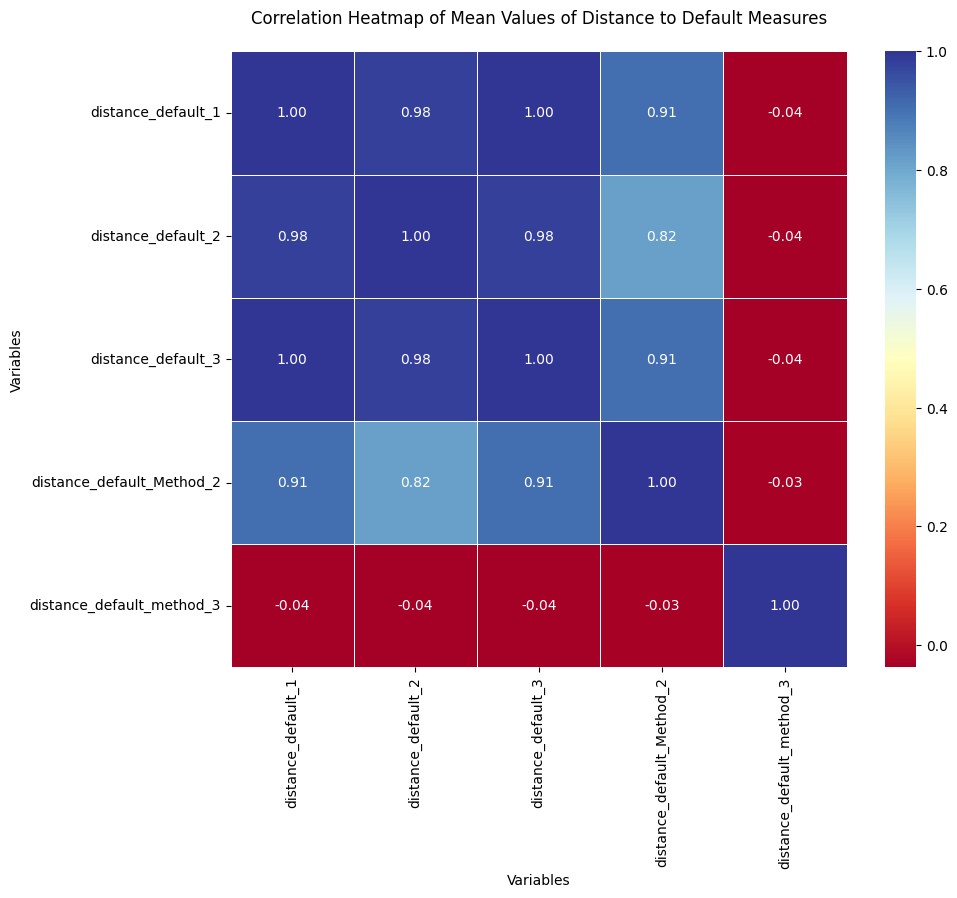

In [56]:
# Calculate the correlation matrix
corr_matrix = mean[['distance_default_1', 'distance_default_2', 'distance_default_3', 
                    'distance_default_Method_2', 'distance_default_method_3']].corr()

# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Mean Values of Distance to Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()


## Correlation Heatmap for mean values of Probability of default measures

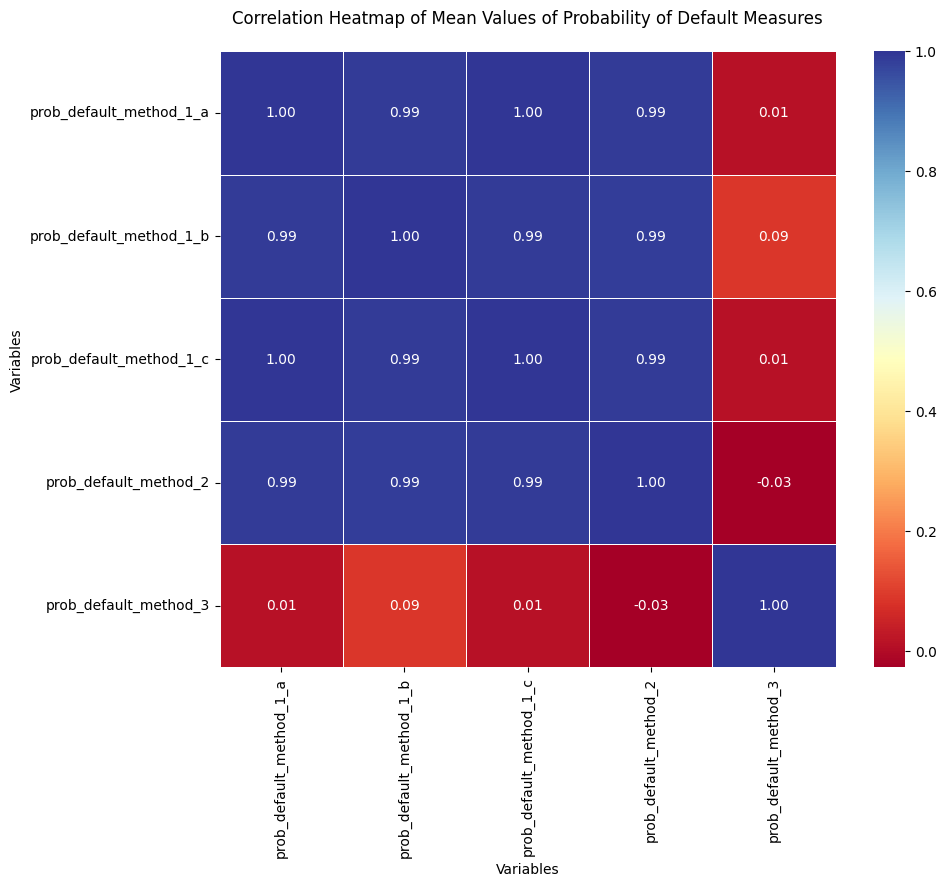

In [57]:
# Calculate the correlation matrix
corr_matrix = mean[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()

# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Mean Values of Probability of Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()


## Correlation Between P25 values of Distance to Default Values based on different computation methods

In [58]:
p25[['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3']].corr()

,distance_default_1,distance_default_2,distance_default_3,distance_default_Method_2,distance_default_method_3
distance_default_1,1.000000,0.990219,1.000000,0.993817,0.509576
distance_default_2,0.990219,1.000000,0.990219,0.972733,0.582383
distance_default_3,1.000000,0.990219,1.000000,0.993817,0.509576
distance_default_Method_2,0.993817,0.972733,0.993817,1.000000,0.464490
distance_default_method_3,0.509576,0.582383,0.509576,0.464490,1.000000


## Correlation Between mean values Probabilty of Default Values based on different computation methods

In [59]:
p25[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()

,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c,prob_default_method_2,prob_default_method_3
prob_default_method_1_a,1.00000,1.000000,1.00000,1.0000,0.082890
prob_default_method_1_b,1.00000,1.000000,1.00000,1.0000,0.082915
prob_default_method_1_c,1.00000,1.000000,1.00000,1.0000,0.082890
prob_default_method_2,1.00000,1.000000,1.00000,1.0000,0.082900
prob_default_method_3,0.08289,0.082915,0.08289,0.0829,1.000000


## Correlation Heatmap P25 values of Distance to Default Values based on different computation methods

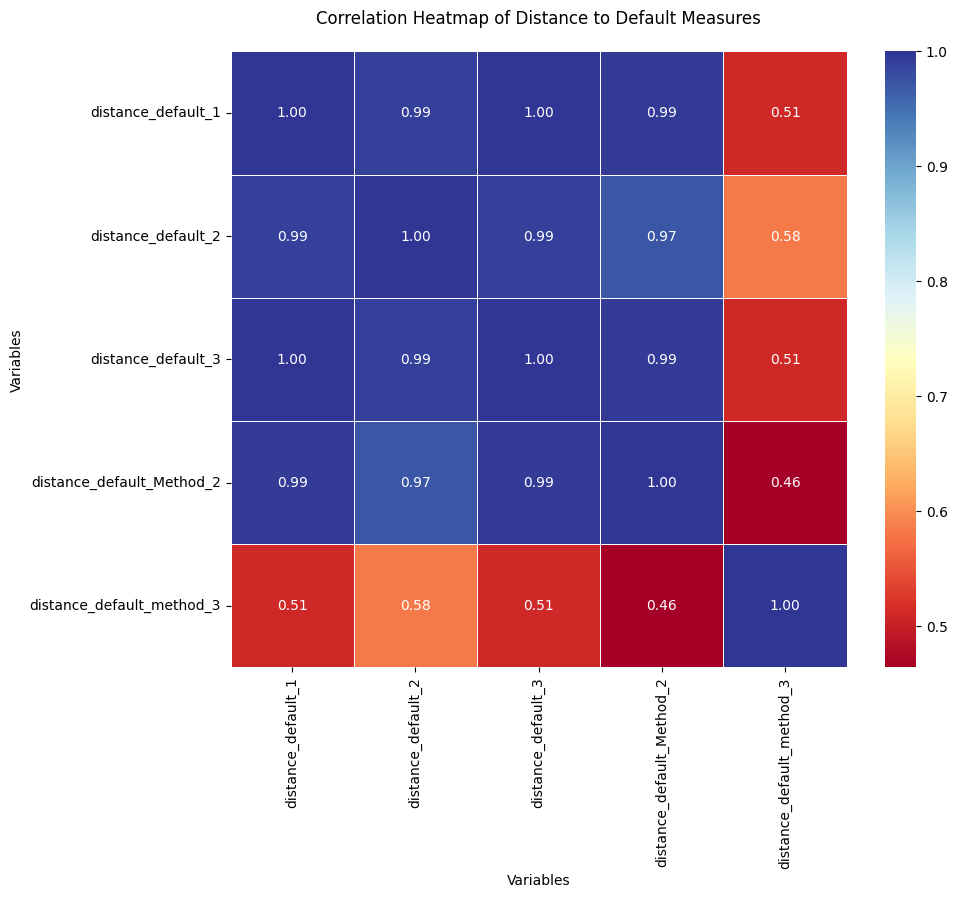

In [53]:
# Calculate the correlation matrix
corr_matrix = p25[['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3']].corr()

# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Distance to Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()


## Correlation Heatmap P25 values of Probability of Default Values based on different computation methods

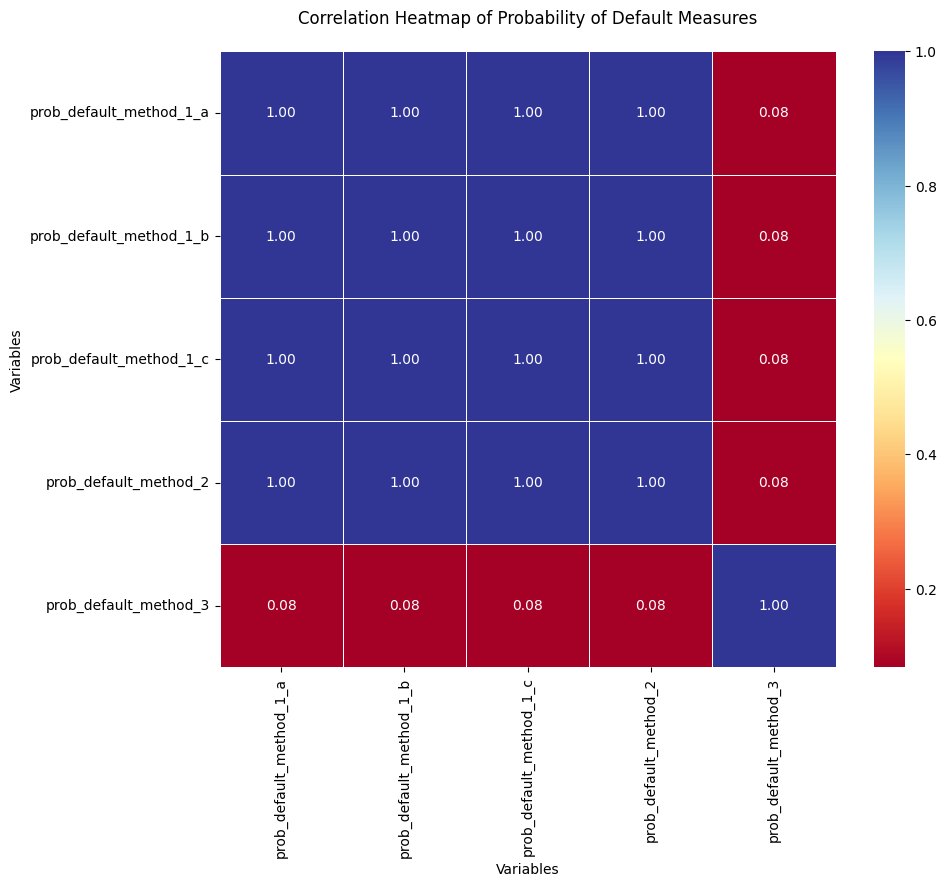

In [60]:
# Calculate the correlation matrix
corr_matrix = p25[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()

# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Probability of Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()


In [61]:
p50[['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3']].corr()

,distance_default_1,distance_default_2,distance_default_3,distance_default_Method_2,distance_default_method_3
distance_default_1,1.000000,0.991792,1.000000,0.993149,0.298453
distance_default_2,0.991792,1.000000,0.991792,0.973902,0.360508
distance_default_3,1.000000,0.991792,1.000000,0.993149,0.298453
distance_default_Method_2,0.993149,0.973902,0.993149,1.000000,0.250815
distance_default_method_3,0.298453,0.360508,0.298453,0.250815,1.000000


In [62]:
p50[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()

,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c,prob_default_method_2,prob_default_method_3
prob_default_method_1_a,1.000000,0.999980,1.000000,0.999999,0.211152
prob_default_method_1_b,0.999980,1.000000,0.999980,0.999974,0.213428
prob_default_method_1_c,1.000000,0.999980,1.000000,0.999999,0.211152
prob_default_method_2,0.999999,0.999974,0.999999,1.000000,0.211167
prob_default_method_3,0.211152,0.213428,0.211152,0.211167,1.000000


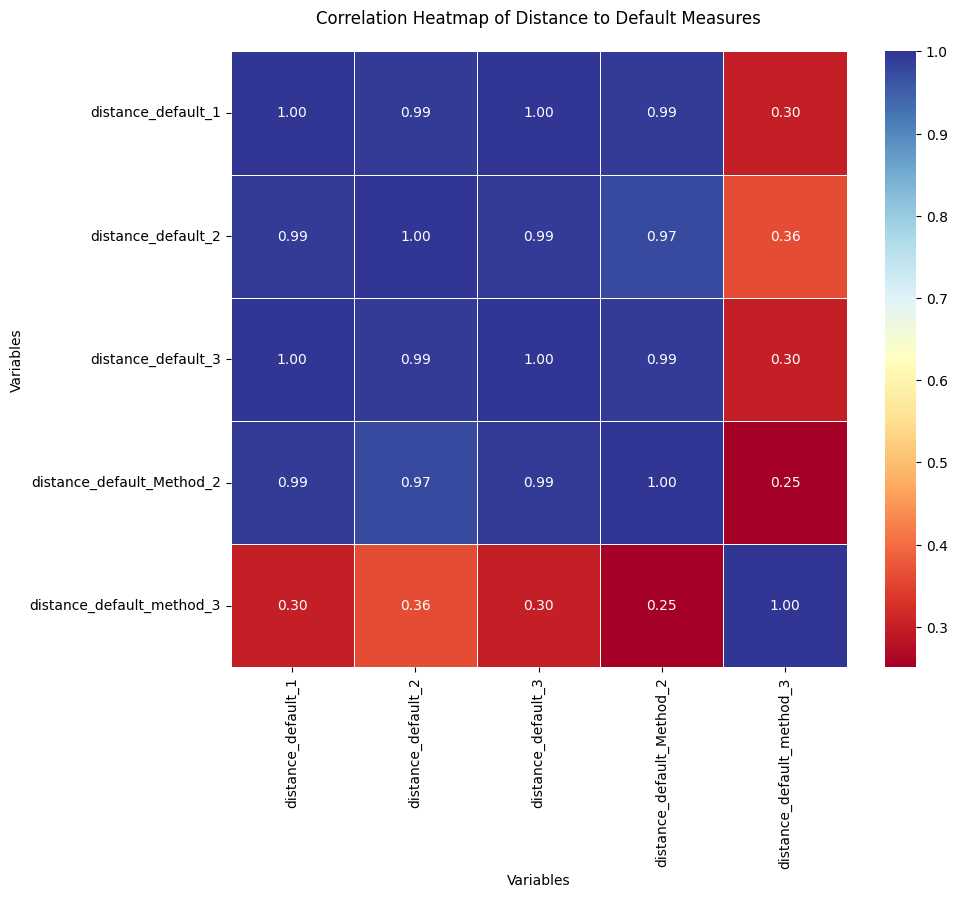

In [63]:
# Calculate the correlation matrix
corr_matrix = p50[['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3']].corr()

# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Distance to Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()


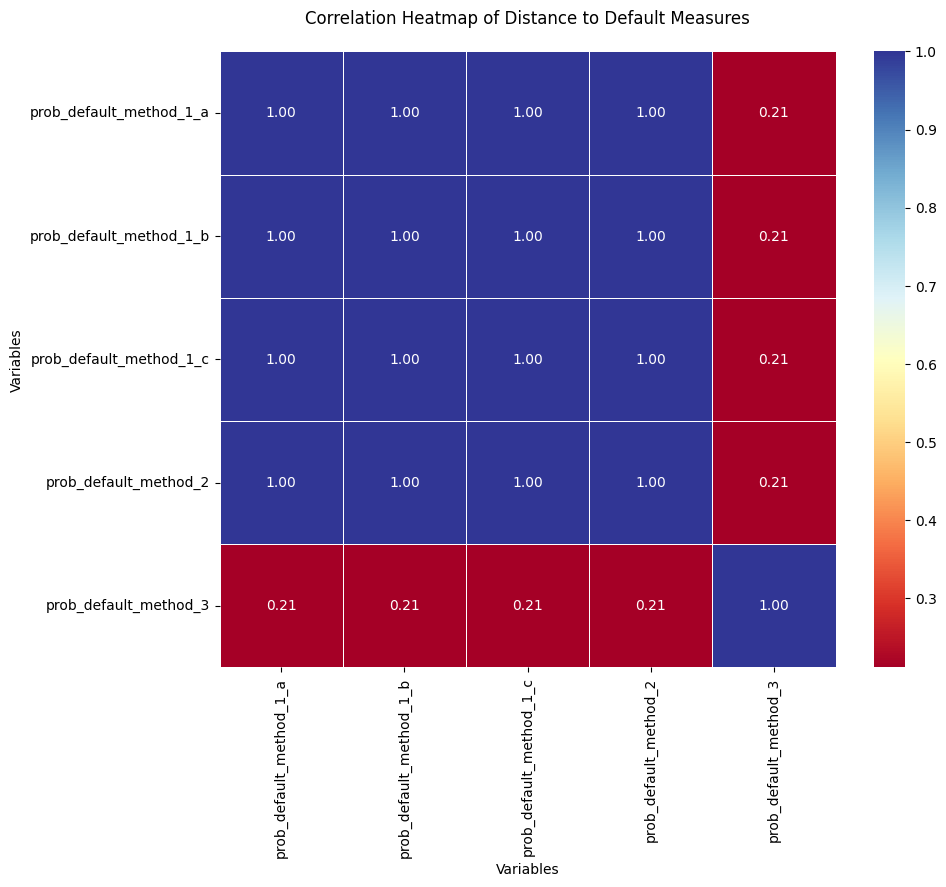

In [64]:
# Calculate the correlation matrix
corr_matrix = p50[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()

# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Distance to Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()


In [65]:
p75[['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3']].corr()

,distance_default_1,distance_default_2,distance_default_3,distance_default_Method_2,distance_default_method_3
distance_default_1,1.000000,0.984789,1.000000,0.989986,-0.071664
distance_default_2,0.984789,1.000000,0.984789,0.958934,0.021266
distance_default_3,1.000000,0.984789,1.000000,0.989986,-0.071664
distance_default_Method_2,0.989986,0.958934,0.989986,1.000000,-0.115489
distance_default_method_3,-0.071664,0.021266,-0.071664,-0.115489,1.000000


In [66]:
p75[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()

,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c,prob_default_method_2,prob_default_method_3
prob_default_method_1_a,1.000000,0.993673,1.000000,0.999612,0.297957
prob_default_method_1_b,0.993673,1.000000,0.993673,0.990480,0.348569
prob_default_method_1_c,1.000000,0.993673,1.000000,0.999612,0.297957
prob_default_method_2,0.999612,0.990480,0.999612,1.000000,0.284378
prob_default_method_3,0.297957,0.348569,0.297957,0.284378,1.000000


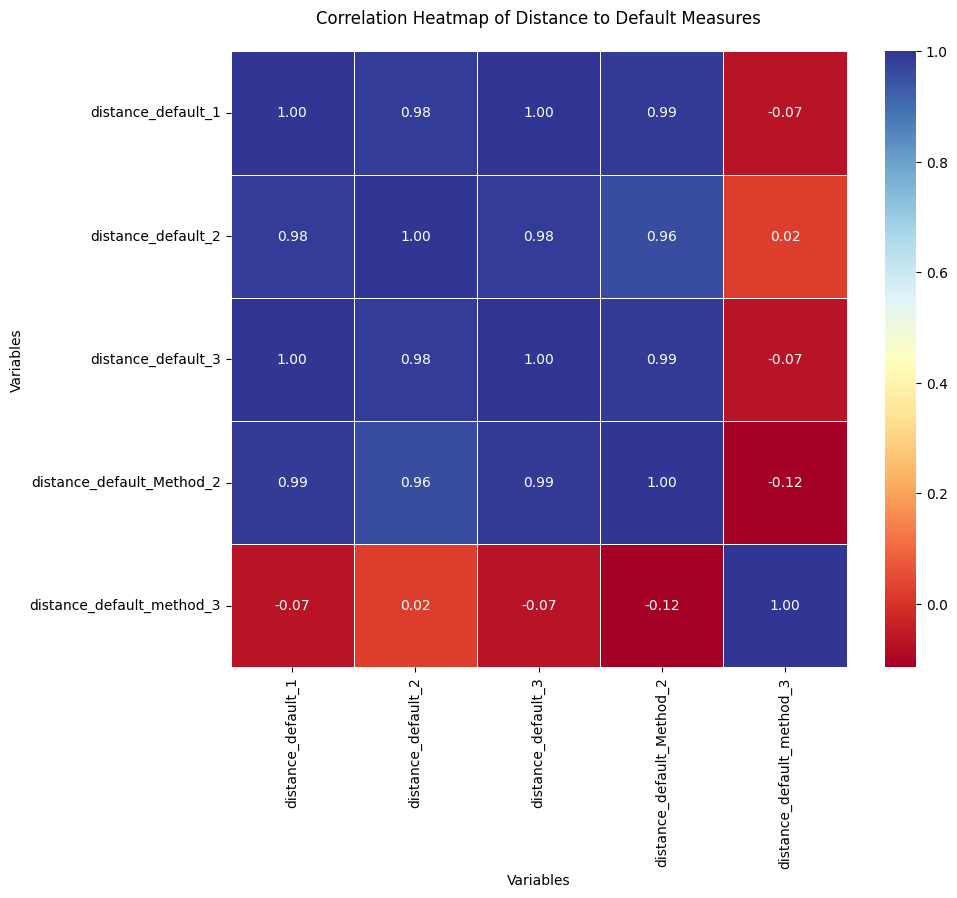

In [67]:
# Calculate the correlation matrix
corr_matrix = p75[['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3']].corr()
# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Distance to Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()

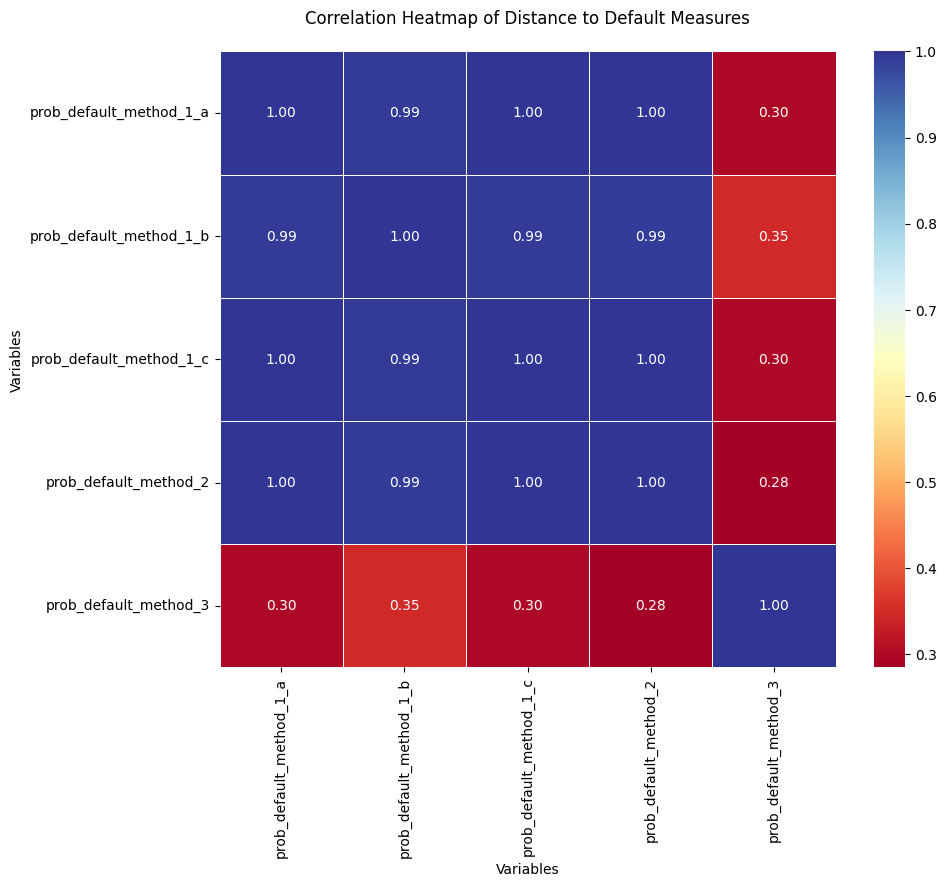

In [68]:
# Calculate the correlation matrix
corr_matrix = p75[['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3']].corr()
# Set the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the RdYlBu color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu', 
            cbar=True, square=True, linewidths=.5)

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Distance to Default Measures', pad=20)
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()

### Plotting Distace to Default and Probability of Default data over time

In [69]:
def plot_graph(data, columns, title):
    # Reshape the data to a long format
    data_long = pd.melt(data, id_vars='year', value_vars=columns, var_name='Measure', value_name='Value')

    # Create a line plot with Seaborn
    sns.set(style="whitegrid")  # Setting the style of the plots
    plt.figure(figsize=(10, 6))  # Size of the plot
    sns.lineplot(x='year', y='Value', hue='Measure', data=data_long, marker='o')

    # Customize the plot
    plt.title(title, fontsize=15)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.legend(title='Measure', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # Place the legend outside

    # Show the plot
    plt.show()

In [93]:
def plot_graph(data, columns, title):
    # Reshape the data to a long format
    data_long = pd.melt(data, id_vars='year', value_vars=columns, var_name='Measure', value_name='Value')

    # Create a line plot with Seaborn
    sns.set(style="whitegrid")  # Setting the style of the plots
    plt.figure(figsize=(10, 6))  # Size of the plot
    sns.lineplot(x='year', y='Value', hue='Measure', data=data_long, marker='o')

    # Customize the plot
    plt.title(title, fontsize=15)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.legend(title='Measure', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # Place the legend outside

    # Show the plot
    plt.show()

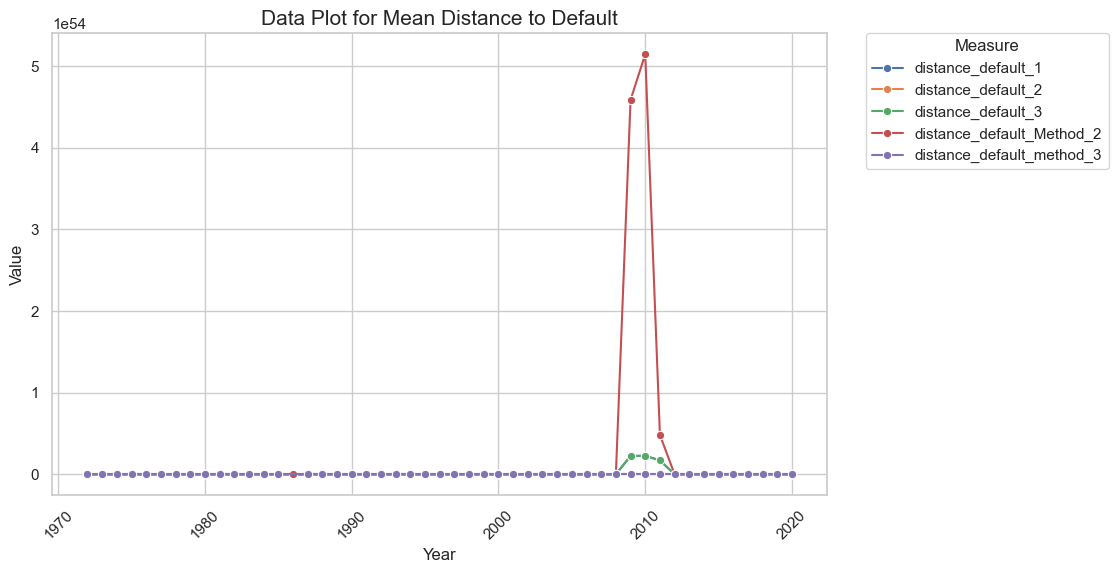

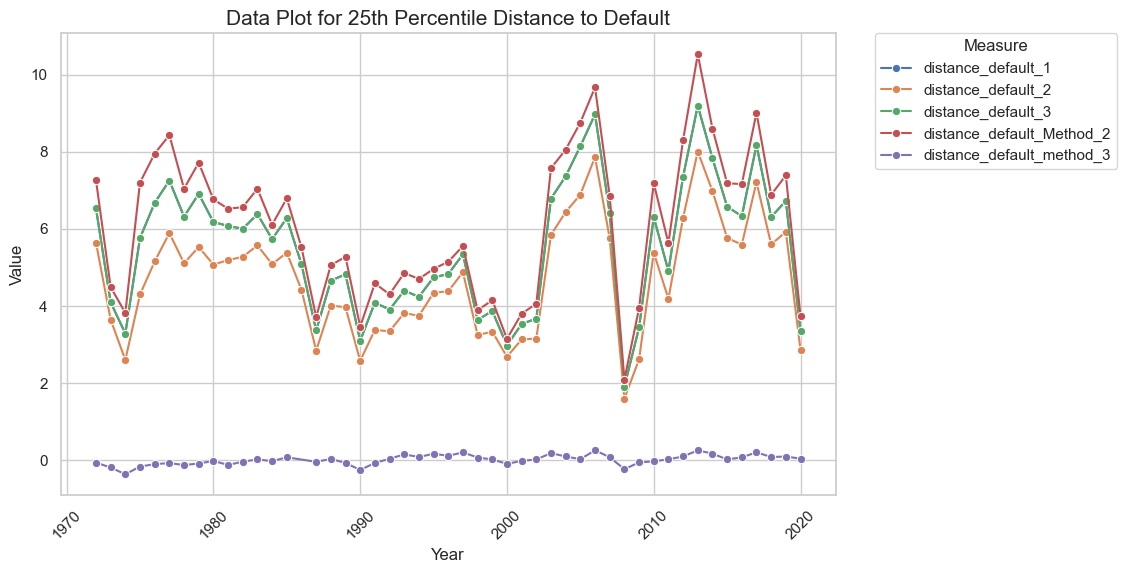

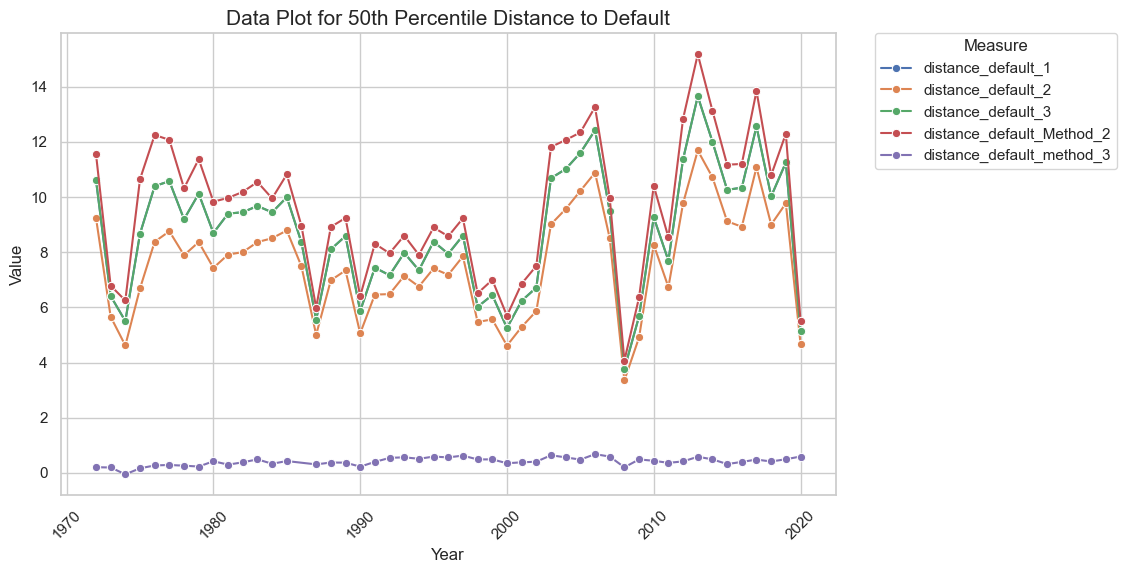

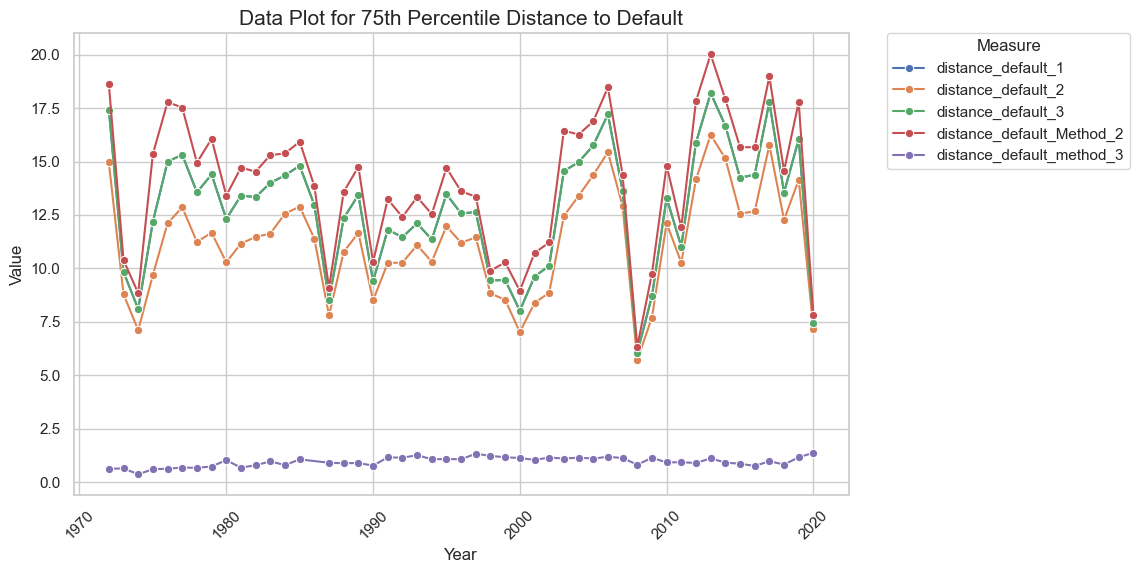

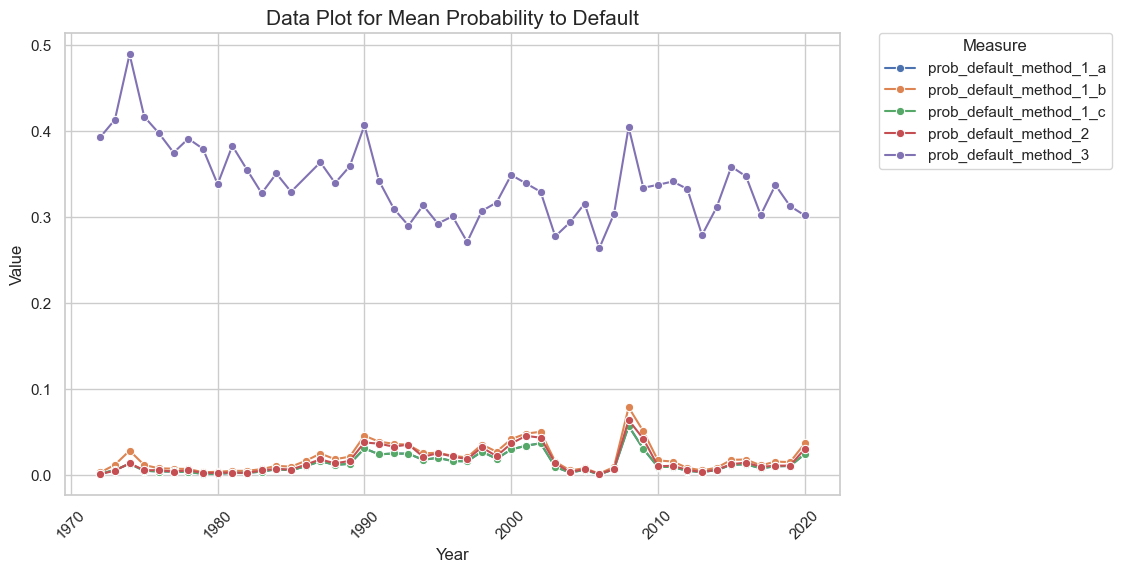

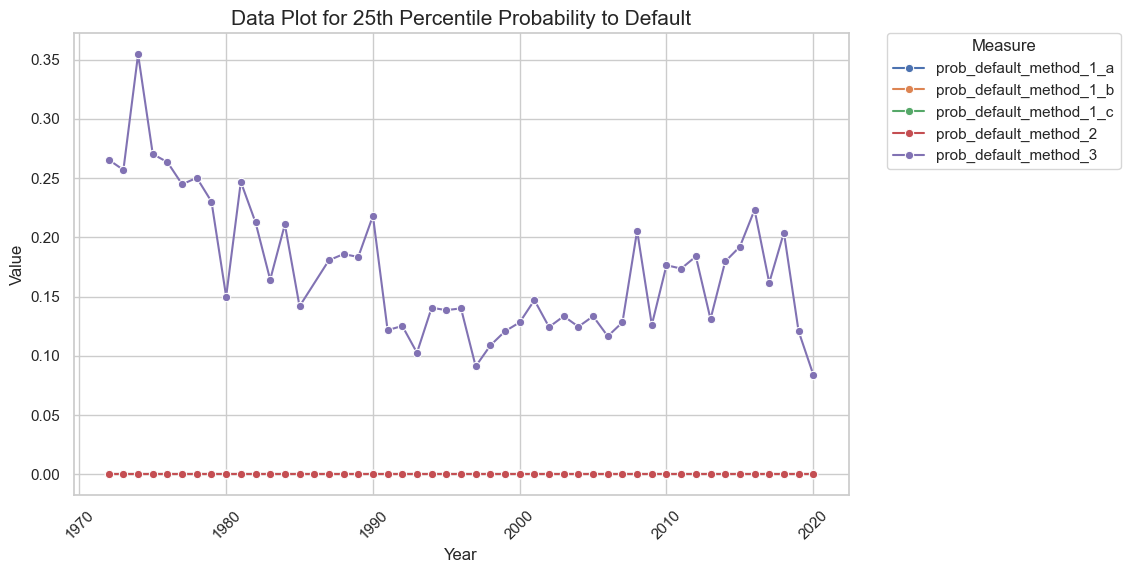

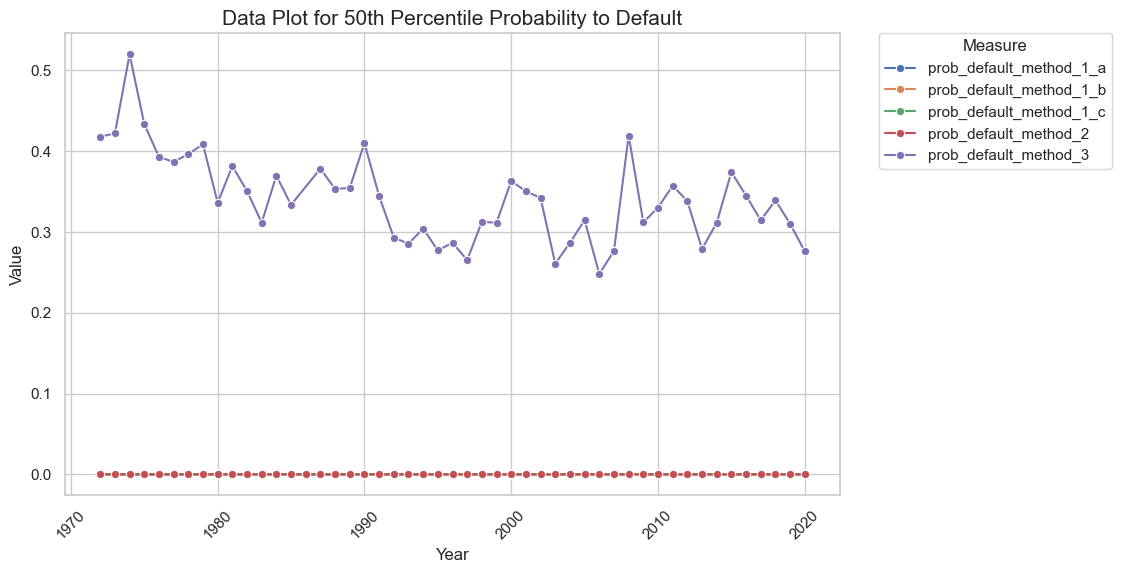

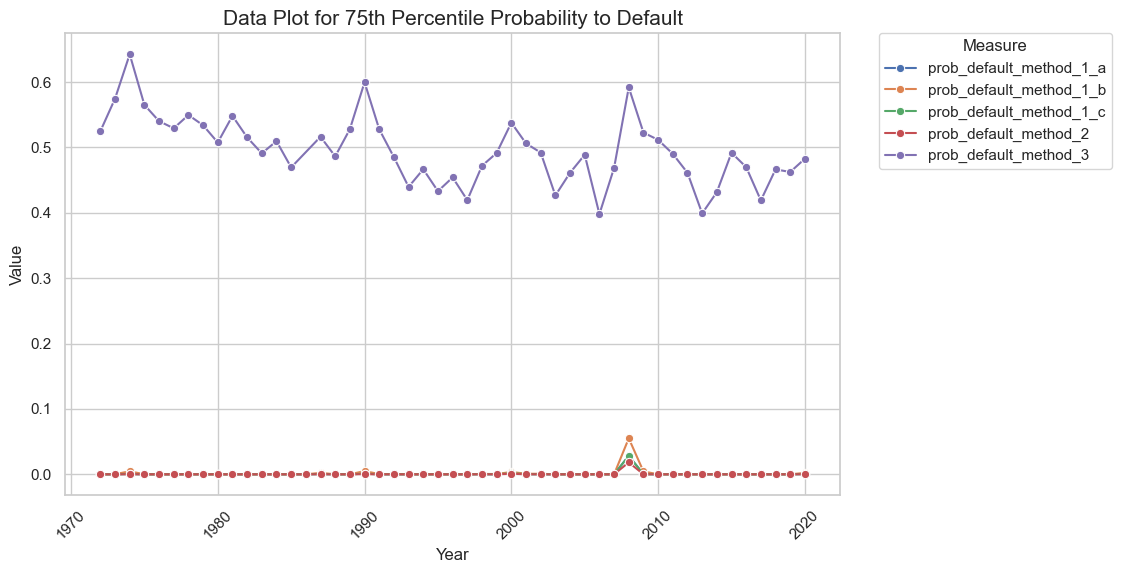

In [74]:
plot_master_data = [
    {'data': mean, 'columns': ['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3'], 'title': 'Data Plot for Mean Distance to Default'},
    {'data': p25, 'columns': ['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3'], 'title': 'Data Plot for 25th Percentile Distance to Default'},
    {'data': p50, 'columns': ['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3'], 'title': 'Data Plot for 50th Percentile Distance to Default'},
    {'data': p75, 'columns': ['distance_default_1', 'distance_default_2', 'distance_default_3', 'distance_default_Method_2', 'distance_default_method_3'], 'title': 'Data Plot for 75th Percentile Distance to Default'},
    {'data': mean, 'columns': ['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3'], 'title': 'Data Plot for Mean Probability to Default'},
    {'data': p25, 'columns': ['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3'], 'title': 'Data Plot for 25th Percentile Probability to Default'},
    {'data': p50, 'columns': ['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3'], 'title': 'Data Plot for 50th Percentile Probability to Default'},
    {'data': p75, 'columns': ['prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c', 'prob_default_method_2', 'prob_default_method_3'], 'title': 'Data Plot for 75th Percentile Probability to Default'}
]

# Loop through the configurations and plot each graph
for idx in plot_master_data:
    plot_data = idx['data'][['year'] + idx['columns']]
    plot_title = idx['title']
    plot_graph(plot_data, idx['columns'], plot_title)


## Time Searies Analysis

- Approach 1: Simplified Estimation Using KMV Framework This strategy employs a basic model to estimate the firm's asset volatility, termed Simplified𝜎𝑉, through a blended average of the stock volatility (𝜎𝐸) along with a pre-defined fixed value. The technique alters the emphasis on the stock volatility across its three distinct variants. Termed 'simplified' due to its fundamental presumption of a linear interplay between stock volatility and asset volatility, this approach may not always encapsulate actual market dynamics or the particular fiscal realities of the business.

- Approach 2: Resolving the Unknowns Directly Utilizing the renowned Black-Scholes option valuation formula and Ito's lemma, this method forms a connection between the firm's value volatility and its equity volatility. It adopts a comprehensive mathematical approach to directly deduce both the firm's worth (𝑉) and asset volatility (𝜎𝑉) from established parameters. Given its foundation in a widely recognized financial model and its consideration of the complex relationship among equity value, debt, and asset volatility, this method tends to yield more precise results.

- Approach 3: Progressive Refinement Using KMV Model Employing the KMV framework, this progressive method begins with a preliminary estimate of asset volatility, which is then refined progressively by analyzing a series of asset values to update the asset volatility estimation. This dynamic approach accommodates fluctuations in the firm's equity volatility over time, thus potentially offering a more accurate and adaptive evaluation of the Distance to Default (DD).

- Analysis of Time Series Graphs: The graphs reveal distinct trends in the Distance to Default (DD), with notable peaks in 2000 and between 2013-2014, and a significant decline in 2008. The surge around 2000 is possibly linked to the dot-com bubble's era of intense speculation in web-based enterprises, where valuations of internet-centric companies skyrocketed, potentially leading to an inflated perception of their financial robustness prior to the bubble's collapse.

- The decline in 2008 aligns with the global financial meltdown, characterized by heightened default risks due to the credit squeeze, faltering mortgage markets, and overall economic downturn. This period was marked by soaring default rates, reflecting in the reduced DD as companies grappled with deteriorating financial health.

- Conversely, the upswing around 2013-2014 likely mirrors a phase of economic rejuvenation. Following the 2008 crisis, global economies gradually stabilized, corporate profits rebounded, and credit conditions relaxed.

- In contrast, the Probability of Default (PD) trends exhibited inverse patterns, hitting their lowest points in 2000 and around 2013-2014, with a pronounced spike in 2008, reflecting the varying economic climates during these periods.

### Analysis of Distance to Default and Probability of Default with respect to US-Recession Data and BAAFM Moody's Data

#### Reading and Transforming Recession Data

In [85]:
import pandas as pd

# Process USREC dataset
# Read the CSV file
USREC = pd.read_csv('USREC.csv')
# Convert 'DATE' to datetime
USREC['DATE'] = pd.to_datetime(USREC['DATE'])
# Extract the year from 'DATE'
USREC['year'] = USREC['DATE'].dt.year
# Convert 'USREC' column to numeric, coercing errors
USREC['USREC'] = pd.to_numeric(USREC['USREC'], errors='coerce')
# Delete the 'DATE' column
del USREC['DATE']

In [86]:
USREC.head()

,USREC,year
0,1,1970
1,1,1970
2,1,1970
3,1,1970
4,1,1970


### Reading and Transforming BAAFM Moody's Data

In [87]:
# Read the CSV file
BAAFFM = pd.read_csv('BAAFFM.csv')
# Convert 'DATE' to datetime
BAAFFM['DATE'] = pd.to_datetime(BAAFFM['DATE'])
# Extract the year from 'DATE'
BAAFFM['year'] = BAAFFM['DATE'].dt.year
# Convert 'BAAFFM' column to numeric, coercing errors
BAAFFM['BAAFFM'] = pd.to_numeric(BAAFFM['BAAFFM'], errors='coerce')
# Delete the 'DATE' column
del BAAFFM['DATE']

In [88]:
BAAFFM.head()

,BAAFFM,year
0,2.70,1954
1,2.27,1954
2,2.41,1954
3,2.61,1954
4,2.62,1954


In [89]:
mean =  pd.merge(mean, USREC , on=['year'], how='left')
mean =  pd.merge(mean, BAAFFM , on=['year'], how='left')

In [90]:
dsf_usrec = pd.merge(merged_data_random_sample, USREC, on=['year'], how='left')
dsf_non_recession = dsf_usrec.loc[dsf_usrec['USREC'] == 0]
dsf_recession = dsf_usrec.loc[dsf_usrec['USREC'] == 1]
dd_iterative_df_usrec = pd.merge(dd_iterative_df, USREC, on=['year'], how='left')
dd_iterative_df_non_recession = dd_iterative_df_usrec.loc[dd_iterative_df_usrec['USREC'] == 0]
dd_iterative_df_recession = dd_iterative_df_usrec.loc[dd_iterative_df_usrec['USREC'] == 1]

### Descriptive stats of DD and PD during non Recessions

In [97]:
dsf_non_recession[['distance_default_1', 'distance_default_2', 'distance_default_3', 
                                  'prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c']].describe()

,distance_default_1,distance_default_2,distance_default_3,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c
count,5.087540e+05,5.087540e+05,5.087540e+05,5.087540e+05,5.087540e+05,5.087540e+05
mean,1.193027e+52,1.273860e+38,1.193027e+52,1.212716e-02,1.824441e-02,1.212716e-02
std,1.566494e+54,1.661307e+40,1.566494e+54,6.683984e-02,8.549829e-02,6.683984e-02
min,-3.793781e+00,-4.178010e+00,-3.793781e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.347908e+00,4.608245e+00,5.347908e+00,2.845485e-41,2.808449e-32,2.845485e-41
50%,8.876957e+00,7.769257e+00,8.876957e+00,3.435710e-19,3.947397e-15,3.435710e-19
75%,1.340449e+01,1.176933e+01,1.340449e+01,4.448827e-08,2.030412e-06,4.448827e-08
max,2.240518e+56,2.312755e+42,2.240518e+56,9.999258e-01,9.999853e-01,9.999258e-01


In [98]:
dsf_non_recession[['distance_default_Method_2', 'prob_default_method_2']].describe()

,distance_default_Method_2,prob_default_method_2
count,5.087540e+05,5.087540e+05
mean,1.849602e+53,1.485136e-02
std,2.932514e+55,8.825795e-02
min,-1.191400e+16,0.000000e+00
25%,5.869270e+00,1.601778e-49
50%,9.717053e+00,1.275276e-22
75%,1.474727e+01,2.188591e-09
max,5.087199e+57,1.000000e+00


In [100]:
dd_iterative_df_non_recession[['distance_default_method_3', 'prob_default_method_3']].describe()

,distance_default_method_3,prob_default_method_3
count,1.263500e+05,126350.000000
mean,1.852541e+15,0.333598
std,2.194926e+17,0.207773
min,-3.512728e+00,0.000000
25%,2.902961e-02,0.163128
50%,4.272386e-01,0.334603
75%,9.816835e-01,0.488420
max,2.600759e+19,0.999778


### Descriptive Stats of DD and PD during reccesion

In [101]:
dsf_recession[['distance_default_1', 'distance_default_2', 'distance_default_3', 
                                  'prob_default_method_1_a', 'prob_default_method_1_b', 'prob_default_method_1_c']].describe()

,distance_default_1,distance_default_2,distance_default_3,prob_default_method_1_a,prob_default_method_1_b,prob_default_method_1_c
count,7.316200e+04,7.316200e+04,7.316200e+04,7.316200e+04,7.316200e+04,7.316200e+04
mean,1.830427e+52,1.689368e+38,1.830427e+52,2.217495e-02,3.439598e-02,2.217495e-02
std,2.021051e+54,1.865317e+40,2.021051e+54,8.499232e-02,1.120954e-01,8.499232e-02
min,-3.793781e+00,-4.178010e+00,-3.793781e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.709559e+00,3.088711e+00,3.709559e+00,2.005200e-24,7.342121e-19,2.005200e-24
50%,6.427447e+00,5.558567e+00,6.427447e+00,6.488228e-11,1.359994e-08,6.488228e-11
75%,1.013136e+01,8.792060e+00,1.013136e+01,1.038103e-04,1.005134e-03,1.038103e-04
max,2.231821e+56,2.059846e+42,2.231821e+56,9.999258e-01,9.999853e-01,9.999258e-01


In [102]:
dsf_recession[['distance_default_Method_2', 'prob_default_method_2']].describe()

,distance_default_Method_2,prob_default_method_2
count,7.316200e+04,7.316200e+04
mean,3.731459e+53,2.687951e-02
std,4.120294e+55,1.147344e-01
min,-3.707785e+14,0.000000e+00
25%,4.144079e+00,4.526932e-29
50%,7.046953e+00,9.143898e-13
75%,1.112911e+01,1.705910e-05
max,4.549987e+57,1.000000e+00


In [103]:
dd_iterative_df_recession[['distance_default_method_3', 'prob_default_method_3']].describe()

,distance_default_method_3,prob_default_method_3
count,1.815400e+04,18154.000000
mean,4.297828e+15,0.386853
std,3.343110e+17,0.227781
min,-3.512728e+00,0.000000
25%,-1.618402e-01,0.206649
50%,2.724002e-01,0.392657
75%,8.181025e-01,0.564284
max,2.600759e+19,0.999778


### Non-Recession Period Stats

-   High Count and Mean Values: The count for all variables is substantial (over 500,000 observations), indicating a robust data set. The mean values, especially for distance_default_1, distance_default_2, and distance_default_3, are exceptionally high, which might suggest either an anomaly in data or extremely high variability in DD measures during non-recession periods.
-   Standard Deviation: The standard deviations are extremely large for certain measures (e.g., distance_default_1, distance_default_2, distance_default_3), suggesting significant variability and potential outliers in the data.
-   Minimum Values: The minimum values are negative for all distance_default measures, which could be indicative of certain firms' extremely poor financial health or data anomalies.
-   Percentiles: The 25th, 50th, and 75th percentiles show a progressive increase, which is expected in a normally distributed dataset. However, the percentile values are quite low compared to the mean, suggesting a skewed distribution.
-   Maximum Values: Extremely high maximum values, especially in the DD measures, indicate the presence of outliers or extreme cases in the dataset.
-   Probability of Default (PD): The PD measures (prob_default_method_1_a, prob_default_method_1_b, etc.) have relatively lower means and standard deviations compared to DD, suggesting less variability in PD during non-recession periods.

### Recession Period Stats

-   Lower Count: The count is significantly lower (around 73,162 for most measures), indicating fewer observations during recession periods.
-   Increased Mean in PD: The mean values for PD measures are higher during the recession, which aligns with the expectation of higher default probabilities in an economic downturn.
-   Standard Deviation: Similar to the non-recession period, the standard deviation values are large, indicating high variability in the data.
-   Lower Percentile Values: The 25th, 50th, and 75th percentile values for DD measures are lower during recessions, reflecting more companies facing financial distress.
-   Probability of Default (PD): PD measures show increased mean values and standard deviations, which is consistent with the expected increase in default risk during economic downturns.
-   Negative Values in DD Measures: The presence of negative values in DD measures during recessions might indicate severe financial distress in certain firms.

### Comparative Analysis

-   Variability and Risk: Both periods show high variability in DD measures, but the recession period exhibits higher PD values, reflecting increased default risk.
-   Data Distribution: The data seems to be skewed with outliers in both periods, more so in non-recession times, indicated by the difference between mean values and percentiles.
-   Economic Impact: The stark differences in PD between recession and non-recession periods underscore the impact of economic conditions on corporate financial health.

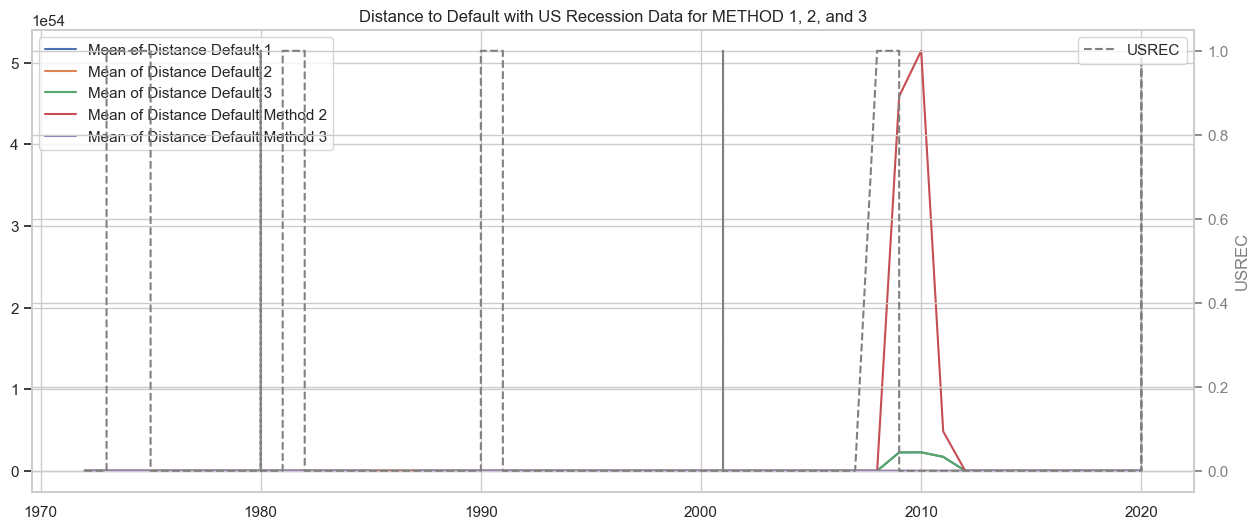

In [113]:
import matplotlib.pyplot as plt

def create_distance_to_default_plot(data, secondary_column, title):
    # Create a figure and a set of subplots with increased size
    fig, ax1 = plt.subplots(figsize=(15, 6))  # Adjust the figsize (width, height) as needed

    # Plotting the Distance to Default measures
    ax1.plot(data['year'], data['distance_default_1'], label='Mean of Distance Default 1')
    ax1.plot(data['year'], data['distance_default_2'], label='Mean of Distance Default 2')
    ax1.plot(data['year'], data['distance_default_3'], label='Mean of Distance Default 3')
    ax1.plot(data['year'], data['distance_default_Method_2'], label='Mean of Distance Default Method 2')
    ax1.plot(data['year'], data['distance_default_method_3'], label='Mean of Distance Default Method 3')

    # Adding secondary data on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(data['year'], data[secondary_column], color='grey', label=secondary_column, linestyle='--')
    ax2.set_ylabel(secondary_column, color='grey')
    ax2.tick_params('y', colors='grey')

    # Title and legend
    plt.title(title)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

# Create the first plot with US Recession Data
create_distance_to_default_plot(mean, 'USREC', 'Distance to Default with US Recession Data for METHOD 1, 2, and 3')


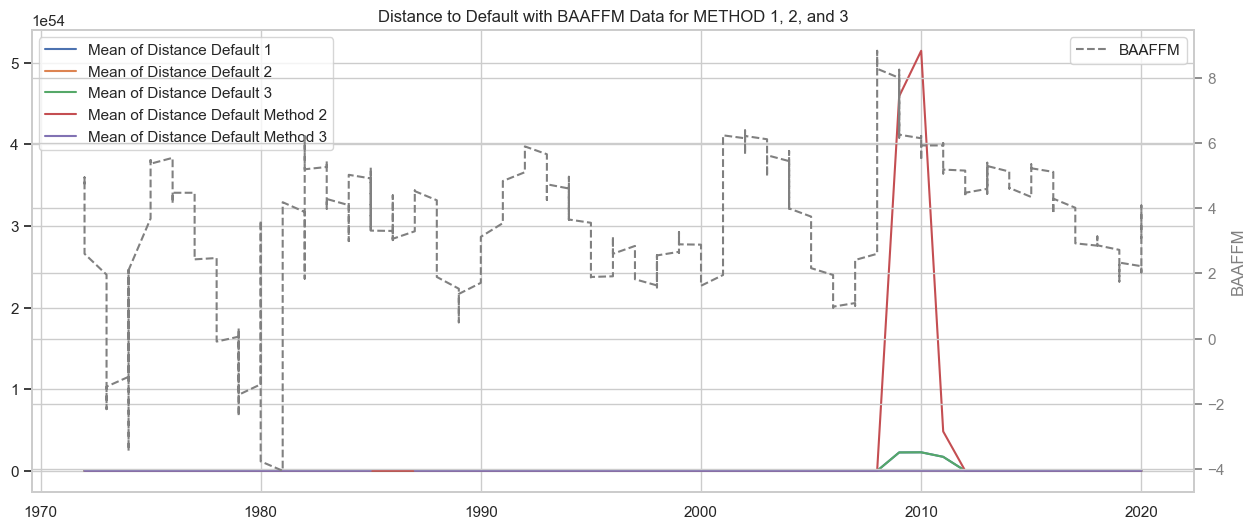

In [114]:
# Create the second plot with BAAFFM Data
create_distance_to_default_plot(mean, 'BAAFFM', 'Distance to Default with BAAFFM Data for METHOD 1, 2, and 3')

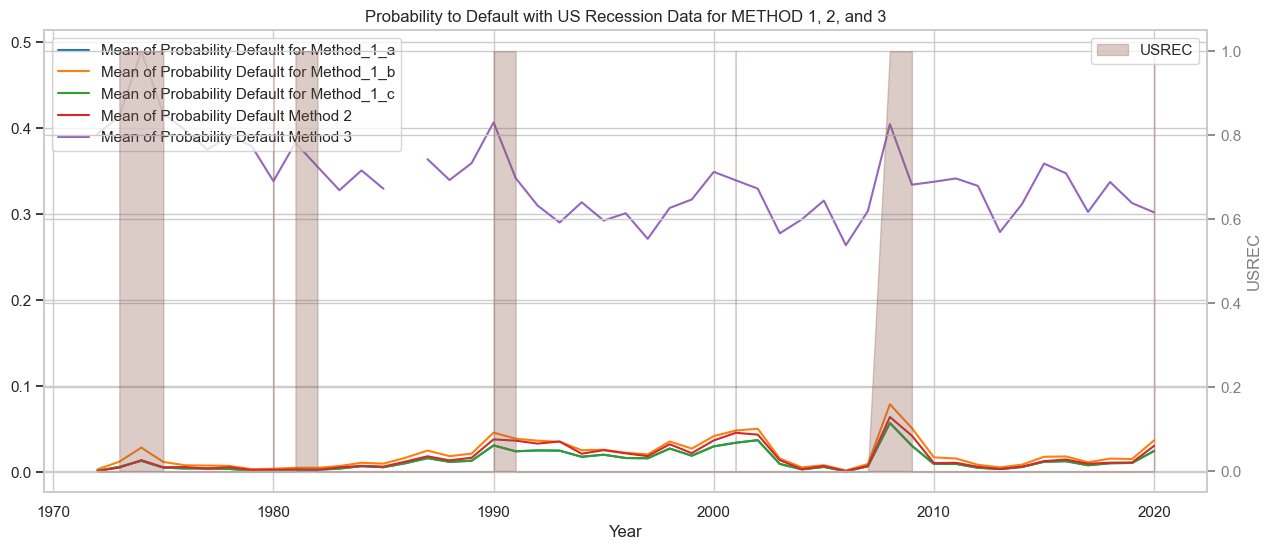

In [116]:
import matplotlib.pyplot as plt

def create_probability_to_default_plot(data, secondary_column, title, line_colors=None, fill_color=None):
    # Default line colors if not provided
    if not line_colors:
        line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    if not fill_color:
        fill_color = '#8c564b'  # Default fill color

    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plotting the Probability of Default measures
    ax1.plot(data['year'], data['prob_default_method_1_a'], label='Mean of Probability Default for Method_1_a', color=line_colors[0])
    ax1.plot(data['year'], data['prob_default_method_1_b'], label='Mean of Probability Default for Method_1_b', color=line_colors[1])
    ax1.plot(data['year'], data['prob_default_method_1_c'], label='Mean of Probability Default for Method_1_c', color=line_colors[2])
    ax1.plot(data['year'], data['prob_default_method_2'], label='Mean of Probability Default Method 2', color=line_colors[3])
    ax1.plot(data['year'], data['prob_default_method_3'], label='Mean of Probability Default Method 3', color=line_colors[4])

    # Adding secondary data on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.fill_between(data['year'], data[secondary_column], color=fill_color, alpha=0.3, label=secondary_column)
    ax2.set_ylabel(secondary_column, color='grey')
    ax2.tick_params('y', colors='grey')

    # Title and legend
    plt.title(title)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set x-axis label
    ax1.set_xlabel('Year')

    # Show the plot
    plt.show()

# Create the first plot with US Recession Data
create_probability_to_default_plot(mean, 'USREC', 'Probability to Default with US Recession Data for METHOD 1, 2, and 3')

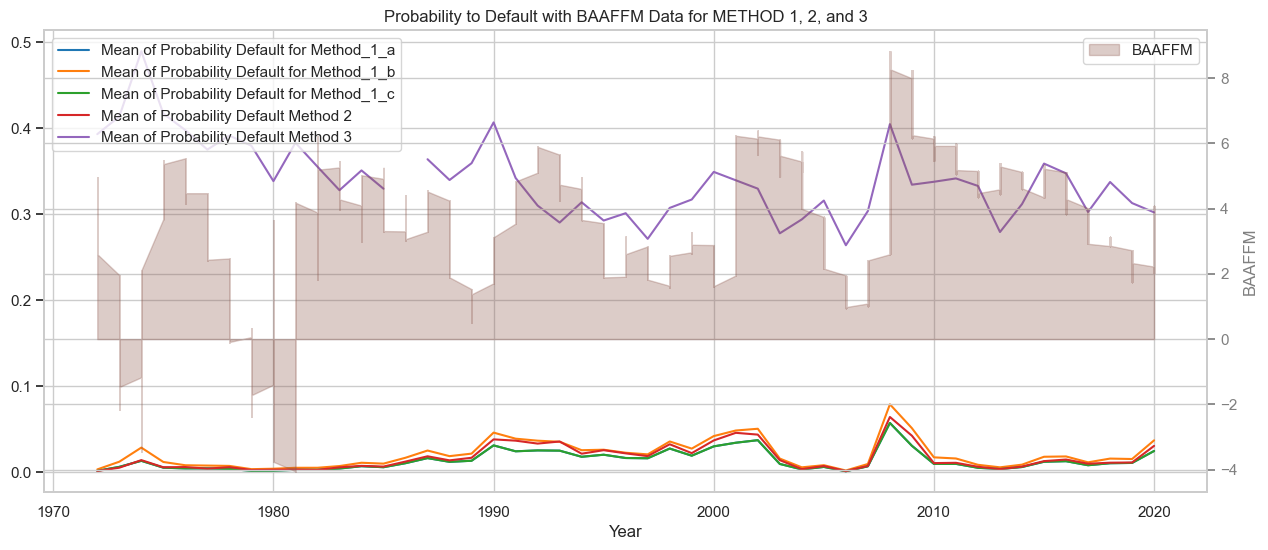

In [117]:
# Create the second plot with BAAFFM Data
create_probability_to_default_plot(mean, 'BAAFFM', 'Probability to Default with BAAFFM Data for METHOD 1, 2, and 3')

### Graph 1: Distance to Default with US Recession Data for METHOD 1, 2, and 3

-   This graph overlays the mean distance to default (DD) calculated by three different methods against the backdrop of US recession periods.
-   The shaded vertical bands indicate US recession periods, likely correlating with significant economic downturns.
-   There is a remarkable spike in one of the DD methods (possibly Method 2 or 3), which seems disproportionately larger than the others. This suggests either a potential outlier, a scale issue, or a period of extreme volatility in the financial stability of firms as measured by this particular method.
-   The DD measures by other methods remain relatively stable across the years, with no drastic fluctuations.
-   During recession periods, there isn't a consistent decrease in the DD metrics, which could imply that the recession's impact on firms' default risk, as captured by these particular DD methods, isn't direct or immediate.

### Graph 2: Distance to Default with BAAFFM Data for METHOD 1, 2, and 3

-   This graph presents a similar analysis but uses BAAFFM data, a measure of the bond yield spread, which can be an indicator of the credit risk perceived by the market.
-   The BAAFFM data is depicted as a dashed line and appears to have peaks that may correspond to economic stress or recession periods, although it's not as clearly marked as in the previous graph.
-   Similar to the first graph, the spike in one of the DD methods stands out, indicating the need for further investigation into the data's accuracy or the method's appropriateness.

### Graph 3: Probability to Default with US Recession Data for METHOD 1, 2, and 3

-   This graph shows the mean probability of default (PD) over time, contrasted with US recession periods.
-   The PD metrics fluctuate over time, with visible increases during recession periods, particularly in the early 2000s and post-2008, which aligns with the expected increase in default risk during economic downturns.
-   The recession periods are again marked by shaded areas, where there's a visible correlation between the economic downturns and the increase in PD, suggesting these metrics may serve as sensitive indicators of financial stress.

### Graph 4: Probability to Default with BAAFFM Data for METHOD 1, 2, and 3

-   This graph shows PD measures alongside BAAFFM data, which is used as a secondary measure of market stress.
-   The BAAFFM data appears to show an increase in credit spread during recession periods, which typically indicates a higher risk environment and could be associated with higher default probabilities.
-   The PD metrics appear more stable compared to the BAAFFM, suggesting that the PD calculated by these methods may not be as sensitive to immediate market conditions as BAAFFM data.

In summary, the graphs indicate that DD and PD metrics have different sensitivities to economic conditions. The spike in one of the DD methods suggests a potential issue with the data or the calculation method. The PD metrics tend to show expected trends, increasing during recessions, which suggests they could be reliable indicators of economic stress. However, the BAAFFM data seems to be a more direct and sensitive indicator of market conditions and financial stress, particularly during recessionary periods. The analysis also underscores the importance of scale and context when interpreting these metrics, as the large spike in DD suggests potential anomalies that could mislead analysis if not properly addressed.